## Pesquisa

Essa pesquisa tem o objetivo de analisar os dados de simulação do Tennessee Eastman com o algoritmo de seleção SHAP, em conjunto com o Random Forest para classificar as falhas, caso sejam ou não a falha informada. Aprofundando no tema, a ideia é utilizar o algortimo SHAP para verificar quais váriaveis conseguem identificar uma falha, por exemplo, unindo todas as falhas e separando uma delas para ser a classe verdadeira, podemos identificar quais variaveis tiveram maior contribuição para aquela especifica falha.

### Separação dos dados

Os dados foram separados em treino, teste e validação. Os dados de treino e de testes foram montados com as primeiras 40 ocorrencias de cada, exceto a selecionada para ser a classe positiva. Já os dados de validação, são os dados não utilizados pelas demais separações.

### Tecnologia implementada

Nesse artigo, foi utilizado o algoritmo SHAP para a seleção das variaveis mais importantes para identificar a falha e o Random Forest para classificar e testar tais variaveis.
Para a classificação, foi utilizado para medir o poder do conjunto utilizando as métrica F1, acuracia, recall, espeficidade e precisão.
Para fins de comparação, foram utilizados alguns gráficos e heatmaps para melhor analise entre artigos selecionados.

In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pylab as plt
from shap_contribution import get_shap_contribution, plot_variable
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import RFE, f_classif, SelectFromModel, mutual_info_classif, SelectKBest
import warnings
import sys
from tabulate import tabulate
from sklearn.multiclass import OneVsOneClassifier
from cstr import get_one_failure, start_df,get_data, get_all_data, get_one_fault, get_one_vs_one_data, get_all_faulty_data
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn")
warnings.filterwarnings("ignore")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [5]:
ignore=[9,11, 17, 18, 20, 21, 22]
l = [ind for ind in range(2,22) if ind not in ignore]

print(l)

faults_range = l

start_df()

[2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 19]


In [9]:
all_features_for_selection = pd.DataFrame(columns=['selector', 'f1_score', 'indexes', 'numberFeatures',
             'fault'])
selected_fault = 1


def select_features(X, y, selector='RFE'):
    global all_features_for_selection
    model = RandomForestClassifier(random_state=1234)
    all_subsets = pd.DataFrame(columns=['selector', 'f1_score', 'indexes', 'numberFeatures',
             'fault'])

    for i in range(1,15):


        if selector == 'RFE':
            featureSelector = RFE(model, n_features_to_select=i)
            featureSelector.fit(X, y)
        if selector == 'FromModel':
            featureSelector = SelectFromModel(estimator=model, max_features=i)
            featureSelector.fit(X, y)
        if selector == 'Classif':
            featureSelector = SelectKBest(f_classif, k=i)
            featureSelector.fit_transform(X, y)
        if selector == 'MultiClassif':
            featureSelector = SelectKBest(mutual_info_classif, k=i)
            featureSelector.fit_transform(X, y)

        indexes = np.nonzero(featureSelector.get_support())

        X_selected = X_train[:, indexes[0]]
        X_test_selected = X_test[:, indexes[0]]

        model = RandomForestClassifier(random_state=1234)
        model.fit(X_selected, y_train)

        predicted = model.predict(X_test_selected)

        result = f1_score(y_test, predicted)

        all_features_for_selection.loc[len(all_features_for_selection)] = {'selector': selector, 'f1_score': result, 'indexes': indexes, 'numberFeatures': len(indexes[0]),
             'fault': selected_fault}
        all_subsets.loc[len(all_subsets)] = {'selector': selector, 'f1_score': result, 'indexes': indexes, 'numberFeatures': len(indexes[0]),
             'fault': selected_fault}

    all_subsets.sort_values(by=['f1_score'], ascending=False, inplace=True)
    return all_subsets['f1_score'][0]

In [6]:
all_contributions = []

for i in faults_range:
    # Setting up the dataset with all falties with binary distribution
    X_train, y_train, X_test, y_test = get_one_failure(i)

    print(X_train.shape, X_test.shape)

    model = RandomForestClassifier(random_state=1234)

    # Calculating the variables contributions
    contributions = get_shap_contribution(model, X_train, y_train, X_test)

    aux = contributions.to_numpy()


    all_contributions.append(aux / aux.sum(axis=0) * 100)

heatmap_data = all_contributions = np.array(all_contributions).reshape(14, 14)

(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)
(750, 14) (250, 14)
14
(250, 14)


### Creating the heat map data with all variables and failures (The heat map is shown in the end of this file)

In [11]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.multiclass import OneVsRestClassifier

# X_train, y_train, X_test, y_test = get_one_vs_one_data(range(2,8))

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # model = KNeighborsClassifier(n_neighbors=3)
# randomForest = RandomForestClassifier(random_state=1234)
# model = OneVsRestClassifier(randomForest)
# model.fit(X_train, y_train)
# predicted = model.predict(X_test)

# # print(predicted)
# # print(y_test)

# f1_aux = f1_score(y_test, predicted, average="weighted")
# accuracy = accuracy_score(y_test, predicted)
# print(f1_aux)
# print(accuracy)

# # model = RandomForestClassifier()
# # model.fit(X_train, y_train)
# # predicted = model.predict(X_test)
# #
# # f1_aux = f1_score(y_test, predicted)
# # print(f1_aux)
# # accuracy = accuracy_score(y_test, predicted)
# # print(accuracy)
# # print(predicted)

# # X_train, y_train, X_test, y_test = get_all_faulty_data(22)
# #
# # print(np.array(X_train).shape)
# # print(np.array(y_test).shape)
# #
# # model = RandomForestClassifier()
# # model.fit(X_train, y_train)
# # predicted = model.predict(X_test)
# #
# # f1_aux = f1_score(y_test, predicted)
# # print(f1_aux)
# # print(predicted)
# # accuracy = accuracy_score(y_test, predicted)
# # print(accuracy)

# X_temporary = np.array([])
# X_test_temporary = np.array([])
# X_train, y_train, X_test, y_test = get_data(6,range(2,8))

# model = RandomForestClassifier(random_state=1234)
# contributions = get_shap_contribution(model, X_train, y_train, X_test, True)

# contribution_indexes = contributions.index.to_numpy()

# for j in range(X_train.shape[1]):
#     print("Contributions")
#     print(contribution_indexes)

#     # Setting up a new dataset with the selected variables
#     X_temporary = np.concatenate((X_temporary, np.array([X_train[:, contribution_indexes[0]]]).T), axis=1) if X_temporary.shape[0] > 0 else np.array([X_train[:,contribution_indexes[0]]]).T
#     X_test_temporary = np.concatenate((X_test_temporary, np.array([X_test[:, contribution_indexes[0]]]).T), axis=1) if X_test_temporary.shape[0] > 0 else np.array([X_test[:, contribution_indexes[0]]]).T

#     print(contribution_indexes)

#     randomForest = RandomForestClassifier(random_state=1234)
#     randomForest.fit(X_temporary, y_train)
#     predicted = randomForest.predict(X_test_temporary)

#     f1_aux = f1_score(y_test, predicted, average="weighted")
#     print(f1_aux)
#     accuracy = accuracy_score(y_test, predicted)
#     print(accuracy)

#     contribution_indexes = np.delete(contribution_indexes, 0)

#     print(predicted)

In [12]:
start_df()
X_train, y_train, X_test, y_test = get_one_failure(5)

X_temporary = np.array([])
X_test_temporary = np.array([])

model = RandomForestClassifier(random_state=1234)
contributions = get_shap_contribution(model, X_train, y_train, X_test, True)

contribution_indexes = contributions.index.to_numpy()

for j in range(X_train.shape[1]):
    print("Contributions")
    print(contribution_indexes)

    # Setting up a new dataset with the selected variables
    X_temporary = np.concatenate((X_temporary, np.array([X_train[:, contribution_indexes[0]]]).T), axis=1) if X_temporary.shape[0] > 0 else np.array([X_train[:,contribution_indexes[0]]]).T
    X_test_temporary = np.concatenate((X_test_temporary, np.array([X_test[:, contribution_indexes[0]]]).T), axis=1) if X_test_temporary.shape[0] > 0 else np.array([X_test[:, contribution_indexes[0]]]).T

    print(contribution_indexes)

    randomForest = RandomForestClassifier(random_state=1234)
    randomForest.fit(X_temporary, y_train)
    predicted = randomForest.predict(X_test_temporary)

    f1_aux = f1_score(y_test, predicted, average="weighted")
    print(f1_aux)
    accuracy = accuracy_score(y_test, predicted)
    print(accuracy)

    contribution_indexes = np.delete(contribution_indexes, 0)

    print(predicted)

14
(250, 14)
Contributions
[ 7 12 13  8  5  9  0 10  4 11  1  2  6  3]
[ 7 12 13  8  5  9  0 10  4 11  1  2  6  3]
0.8225882352941176
0.844
[0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1
 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Contributions
[12 13  8  5  9  0 10  4 11  1  2  6  3]
[12 13  8  5  9  0 10  4 11  1  2  6  3]
0.7608411548057503
0.82
[0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 

### Calculating with all metrics and selecting the best variables for each failures

In [13]:
all_contributions = pd.DataFrame(columns=['index', 'value'])
all_accuracies = pd.DataFrame(columns=['index', 'f1', 'accuracy', 'recall', 'precision', 'specificity',
             'tn', 'fp', 'fn', 'tp', 'scores', 'all_scores',
             'used_variables', 'all_variables', 'rfe',
             'fromModel', 'class', 'multiclass'])

for i in faults_range:
    global selected_fault

    selected_fault = i
    # Setting up the dataset with all falties with binary distribution
    print("Fault")
    print(i)
    X_train, y_train, X_test, y_test = get_one_failure(i)

    model = RandomForestClassifier(random_state=1234)

    # Calculating the variables contributions
    contributions = get_shap_contribution(model, X_train, y_train, X_test, True)

    accuracies = []
    f1s = []
    recalls = []
    precisions = []
    specificities = []

    all_scores = []
    scores = []
    used_variables = []
    all_variables = contribution_indexes = contributions.index.to_numpy()

    X_temporary = np.array([])
    X_test_temporary = np.array([])

    stop = False

    selectorsF1 = []

    for selectorName in ['RFE', 'FromModel', 'Classif', 'MultiClassif']:
        selectorsF1.append(select_features(X_train, y_train, selectorName))

    for j in range(X_train.shape[1]):
        model = RandomForestClassifier(random_state=1234)

        print("Contributions")
        print(contribution_indexes)

        # Setting up a new dataset with the selected variables
        X_temporary = np.concatenate((X_temporary, np.array([X_train[:, contribution_indexes[0]]]).T), axis=1) if X_temporary.shape[0] > 0 else np.array([X_train[:,contribution_indexes[0]]]).T
        X_test_temporary = np.concatenate((X_test_temporary, np.array([X_test[:, contribution_indexes[0]]]).T), axis=1) if X_test_temporary.shape[0] > 0 else np.array([X_test[:, contribution_indexes[0]]]).T

        print("Shapes:")
        print(np.array(X_temporary).shape)
        print(np.array(X_test_temporary).shape)

        model.fit(X_temporary, y_train)
        predicted = model.predict(X_test_temporary)

        # Calculating all metrics
        f1_aux = f1_score(y_test, predicted)
        accuracy_aux = accuracy_score(y_test, predicted)
        recall_aux = recall_score(y_test, predicted)
        precision_aux = precision_score(y_test, predicted)
        tn_aux, fp_aux, fn_aux, tp_aux = confusion_matrix(y_test, predicted).ravel()
        specificity_aux = tn_aux / (tn_aux + fp_aux)

        print("F1 Accuracy")
        print(f1_aux)

        if (len(scores) == 0 or (len(scores) > 0 and scores[len(scores) - 1] < f1_aux)):
            used_variables.append(contribution_indexes[0])
            scores.append(f1_aux)
            f1 = f1_aux
            accuracy = accuracy_aux
            recall = recall_aux
            precision = precision_aux
            tn = tn_aux
            fp = fp_aux
            fn = fn_aux
            tp = tp_aux
            specificity = specificity_aux

        contribution_indexes = np.delete(contribution_indexes, 0)

        all_scores.append(f1_aux)

        print("Used Variables")
        print(used_variables)

        print("Index")
        print(i)

    # Adding this accuracy to the dataframe
    all_accuracies.loc[len(all_accuracies)] = {'index': i, 'f1': f1, 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'specificity': specificity,
             'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp, 'scores': scores, 'all_scores': all_scores,
             'used_variables': used_variables, 'all_variables': all_variables, 'rfe': selectorsF1[0],
             'fromModel': selectorsF1[1], 'class': selectorsF1[2], 'multiclass': selectorsF1[3]}

    # Adding this contribution to the dataframe
    all_contributions.loc[len(all_contributions)] = {'index': i, 'value': contributions.index}

Fault
2
14
(250, 14)
Contributions
[11  9 10  0  5 13  1  7  4 12  6  3  8  2]
Shapes:
(750, 1)
(250, 1)
F1 Accuracy
0.8779342723004695
Used Variables
[11]
Index
2
Contributions
[ 9 10  0  5 13  1  7  4 12  6  3  8  2]
Shapes:
(750, 2)
(250, 2)
F1 Accuracy
0.9016018306636155
Used Variables
[11, 9]
Index
2
Contributions
[10  0  5 13  1  7  4 12  6  3  8  2]
Shapes:
(750, 3)
(250, 3)
F1 Accuracy
0.8959276018099549
Used Variables
[11, 9]
Index
2
Contributions
[ 0  5 13  1  7  4 12  6  3  8  2]
Shapes:
(750, 4)
(250, 4)
F1 Accuracy
0.8979591836734694
Used Variables
[11, 9]
Index
2
Contributions
[ 5 13  1  7  4 12  6  3  8  2]
Shapes:
(750, 5)
(250, 5)
F1 Accuracy
0.8929384965831434
Used Variables
[11, 9]
Index
2
Contributions
[13  1  7  4 12  6  3  8  2]
Shapes:
(750, 6)
(250, 6)
F1 Accuracy
0.8963963963963965
Used Variables
[11, 9]
Index
2
Contributions
[ 1  7  4 12  6  3  8  2]
Shapes:
(750, 7)
(250, 7)
F1 Accuracy
0.9009009009009009
Used Variables
[11, 9]
Index
2
Contributions
[ 7  4 12

##### Simple metrics results

In [14]:
print(tabulate(all_accuracies.drop(
    ['scores', 'all_scores', 'used_variables', 'all_variables', 'rfe', 'fromModel', 'class', 'multiclass'],
    axis=1).round(4), tablefmt='psql', headers="keys"))

+----+---------+--------+------------+----------+-------------+---------------+------+------+------+------+
|    |   index |     f1 |   accuracy |   recall |   precision |   specificity |   tn |   fp |   fn |   tp |
|----+---------+--------+------------+----------+-------------+---------------+------+------+------+------|
|  0 |       2 | 0.9016 |      0.828 |    0.985 |      0.8312 |          0.2  |   10 |   40 |    3 |  197 |
|  1 |       3 | 0.8909 |      0.808 |    0.98  |      0.8167 |          0.12 |    6 |   44 |    4 |  196 |
|  2 |       4 | 0.8864 |      0.8   |    0.975 |      0.8125 |          0.1  |    5 |   45 |    5 |  195 |
|  3 |       5 | 0.9082 |      0.844 |    0.965 |      0.8578 |          0.36 |   18 |   32 |    7 |  193 |
|  4 |       6 | 0.8969 |      0.816 |    1     |      0.813  |          0.08 |    4 |   46 |    0 |  200 |
|  5 |       7 | 0.9281 |      0.876 |    1     |      0.8658 |          0.38 |   19 |   31 |    0 |  200 |
|  6 |       8 | 0.9153 |   

##### Selected variables and scores

In [15]:
temporary_df = all_accuracies.copy()

for i in range(len(temporary_df['scores'])):
    for j in range(len(temporary_df['scores'][i])):
        temporary_df['scores'][i][j] = round(temporary_df['scores'][i][j], 4)

print(tabulate(temporary_df[['index', 'scores', 'used_variables']], tablefmt='psql', headers='keys',
               maxcolwidths=[1, 1, 50, 50]))

+----+---------+-------------------------------------------------+---------------------------+
|    |   index | scores                                          | used_variables            |
|----+---------+-------------------------------------------------+---------------------------|
|  0 |       2 | [0.8779, 0.9016]                                | [11, 9]                   |
|  1 |       3 | [0.851, 0.8685, 0.8822, 0.8843, 0.8853, 0.8889, | [12, 13, 10, 9, 11, 1, 3] |
|    |         | 0.8909]                                         |                           |
|  2 |       4 | [0.8437, 0.8802, 0.8864]                        | [13, 12, 7]               |
|  3 |       5 | [0.9082]                                        | [7]                       |
|  4 |       6 | [0.891, 0.8914, 0.8924, 0.8969]                 | [11, 8, 9, 0]             |
|  5 |       7 | [0.9281]                                        | [11]                      |
|  6 |       8 | [0.9112, 0.9132, 0.9153]         

##### All variables and scores

In [16]:
for i in range(len(temporary_df['all_scores'])):
    for j in range(len(temporary_df['all_scores'][i])):
        temporary_df['all_scores'][i][j] = round(temporary_df['all_scores'][i][j], 4)

print(tabulate(all_accuracies[['index', 'all_scores', 'all_variables']], tablefmt='psql', headers='keys',
               maxcolwidths=[1, 1, 50, 50]))

+----+---------+--------------------------------------------------+---------------------------------------------+
|    |   index | all_scores                                       | all_variables                               |
|----+---------+--------------------------------------------------+---------------------------------------------|
|  0 |       2 | [0.8779, 0.9016, 0.8959, 0.898, 0.8929, 0.8964,  | [11  9 10  0  5 13  1  7  4 12  6  3  8  2] |
|    |         | 0.9009, 0.8969, 0.8904, 0.8969, 0.8989, 0.8949,  |                                             |
|    |         | 0.8929, 0.8929]                                  |                                             |
|  1 |       3 | [0.851, 0.8685, 0.8822, 0.8843, 0.8853, 0.8853,  | [12 13 10  9 11  7  0  1  5  4  3  6  2  8] |
|    |         | 0.8813, 0.8889, 0.8787, 0.8874, 0.8909, 0.8899,  |                                             |
|    |         | 0.8824, 0.8874]                                  |                     

##### Score results with selected variables

In [17]:
# for failure in range(7):
#     plt.plot(all_accuracies["all_scores"][failure], zorder=1)
#     plt.xticks(range(14), all_accuracies["all_variables"][failure], fontsize=8, rotation=90)

#     plt.scatter(x=len(all_accuracies["used_variables"][failure]) - 1,
#                 y=next(reversed(all_accuracies["scores"][failure])), color='r', zorder=2)
#     plt.title("Failure " + str(failure + 1))
#     plt.show()

##### Heatmaps

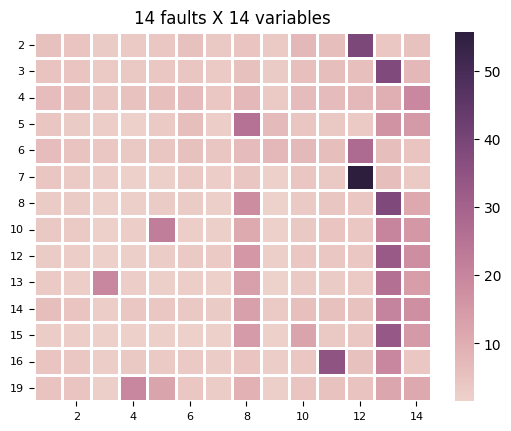

In [7]:
np.set_printoptions(threshold=sys.maxsize, suppress=True)
np.set_printoptions()

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig = plt.figure()
heat_map = sns.heatmap(heatmap_data, linewidth=1, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('14 faults X 14 variables')
plt.yticks(np.arange(1, 15, 1) - 0.5, faults_range, fontsize=8, rotation=0, va='center')
plt.xticks(np.arange(1, 15, 2) + 0.5, np.arange(1, 15, 2) + 1, fontsize=8)
plt.show()
fig.savefig("figures/cstr/2152.eps", format='eps')
plt.close()

    index        f1  accuracy  recall  precision  specificity  tn  fp  fn  \
0       2  0.901602     0.828   0.985   0.831224         0.20  10  40   3   
1       3  0.890909     0.808   0.980   0.816667         0.12   6  44   4   
2       4  0.886364     0.800   0.975   0.812500         0.10   5  45   5   
3       5  0.908235     0.844   0.965   0.857778         0.36  18  32   7   
4       6  0.896861     0.816   1.000   0.813008         0.08   4  46   0   
5       7  0.928074     0.876   1.000   0.865801         0.38  19  31   0   
6       8  0.915332     0.852   1.000   0.843882         0.26  13  37   0   
7      10  0.913242     0.848   1.000   0.840336         0.24  12  38   0   
8      12  0.909091     0.840   1.000   0.833333         0.20  10  40   0   
9      13  0.911162     0.844   1.000   0.836820         0.22  11  39   0   
10     14  0.900901     0.824   1.000   0.819672         0.12   6  44   0   
11     15  0.919540     0.860   1.000   0.851064         0.30  15  35   0   

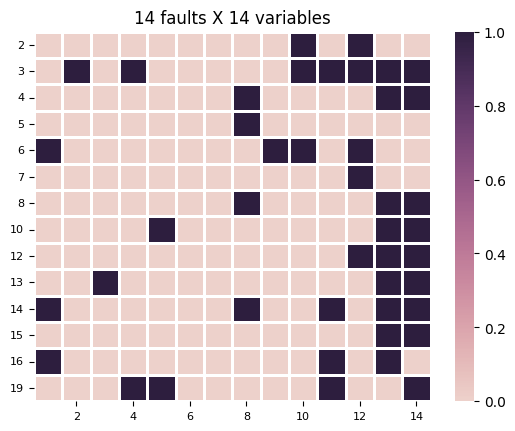

In [8]:
binary_heatmap_data = []

print(all_accuracies)

for i in range(14):
    binary_heatmap_data.append([])

    for j in range(14):
        binary_heatmap_data[i].append(0)

    for x in all_accuracies['used_variables'].to_numpy()[i]:
        binary_heatmap_data[i][x] = 1

fig2 = plt.figure()
heat_map = sns.heatmap(binary_heatmap_data, linewidth=1, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('14 faults X 14 variables')
plt.yticks(np.arange(1, 15, 1) - 0.5, faults_range, fontsize=8, rotation=0, va='center')
plt.xticks(np.arange(1, 14, 2) + 0.5, np.arange(1, 14, 2) + 1, fontsize=8)
plt.show()
fig2.savefig("figures/cstr/21525.eps", format='eps')
plt.close()

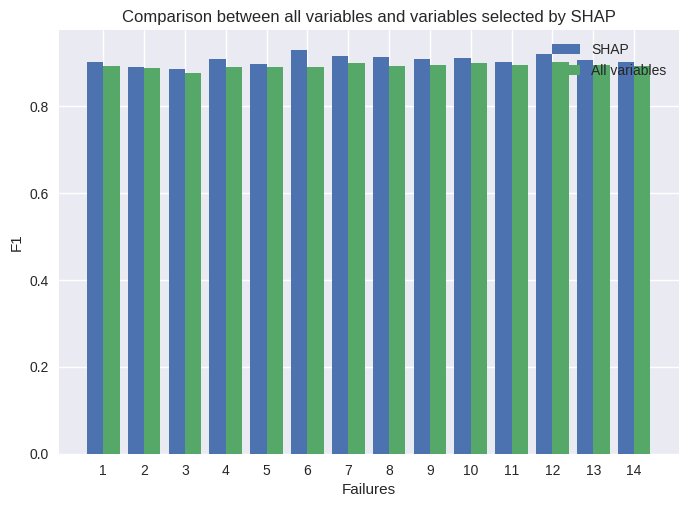

In [38]:
scores_bar = []
all_scores_bar = []

for i in range(len(faults_range)):
    scores_aux = all_accuracies['scores'].to_numpy()[i]
    all_scores_aux = all_accuracies['all_scores'].to_numpy()[i]

    scores_bar.append(scores_aux[len(scores_aux) - 1])
    all_scores_bar.append(all_scores_aux[len(all_scores_aux) - 1])

plt.bar(np.arange(14) - 0.2, scores_bar, 0.4, label="SHAP")
plt.bar(np.arange(14) + 0.2, all_scores_bar, 0.4, label="All variables")

plt.xticks(range(14), range(1, 15))
plt.xlabel("Failures")
plt.ylabel("F1")
plt.title("Comparison between all variables and variables selected by SHAP")
plt.legend()
plt.show()

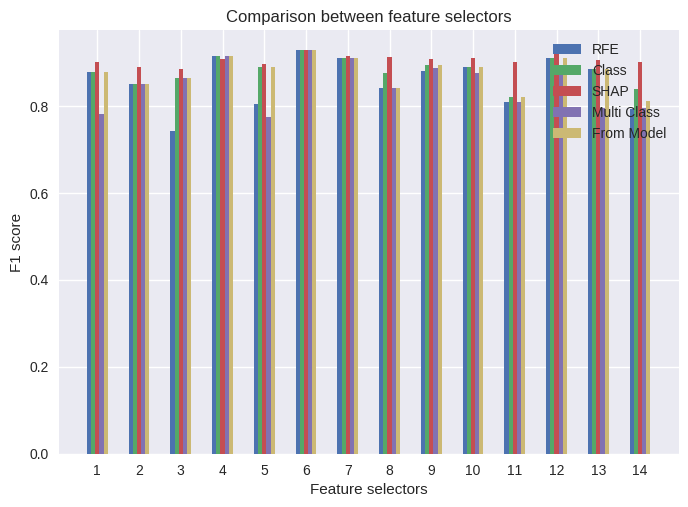

In [39]:
rfe_score = all_accuracies['rfe']
class_score = all_accuracies['class']
shap_score = all_accuracies['f1']
multi_score = all_accuracies['multiclass']
model_score = all_accuracies['fromModel']

plt.bar(np.arange(14) - 0.2, rfe_score, 0.1, label="RFE")
plt.bar(np.arange(14) - 0.1, class_score, 0.1, label="Class")
plt.bar(np.arange(14), shap_score, 0.1, label="SHAP")
plt.bar(np.arange(14) + 0.1, multi_score, 0.1, label="Multi Class")
plt.bar(np.arange(14) + 0.2, model_score, 0.1, label="From Model")

plt.xticks(range(14), range(1, 15))
plt.xlabel("Feature selectors")
plt.ylabel("F1 score")
plt.title("Comparison between feature selectors")
plt.legend()

In [ ]:
all_features_for_selection.sort_values(by=['f1_score', 'numberFeatures'], ascending=[False, True], inplace=True)

In [ ]:
print(all_features_for_selection.loc[
          (all_features_for_selection['fault'] == 3) & (all_features_for_selection['selector'] == 'RFE')])

   selector  f1_score                                            indexes  \
62      RFE  0.893424                       ([5, 7, 8, 10, 11, 12, 13],)   
58      RFE  0.890951                                     ([7, 12, 13],)   
68      RFE  0.889391     ([0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],)   
67      RFE  0.888889        ([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],)   
63      RFE  0.887872                    ([4, 5, 7, 8, 10, 11, 12, 13],)   
60      RFE  0.886311                               ([5, 7, 8, 12, 13],)   
65      RFE  0.885845              ([0, 4, 5, 7, 8, 9, 10, 11, 12, 13],)   
64      RFE  0.884793                 ([4, 5, 7, 8, 9, 10, 11, 12, 13],)   
69      RFE  0.884354  ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],)   
61      RFE  0.879630                           ([5, 7, 8, 11, 12, 13],)   
66      RFE  0.876712           ([0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],)   
59      RFE  0.876457                                  ([5, 7, 12, 13],)   
57      RFE 

In [ ]:
print(all_features_for_selection.drop_duplicates(subset=['selector', 'fault']))

         selector  f1_score  \
280           RFE  0.928074   
294     FromModel  0.928074   
308       Classif  0.928074   
322  MultiClassif  0.928074   
617           RFE  0.919540   
631     FromModel  0.919540   
659  MultiClassif  0.919540   
183     FromModel  0.917431   
491  MultiClassif  0.916667   
337           RFE  0.915332   
351     FromModel  0.915332   
365       Classif  0.915332   
168           RFE  0.915094   
196       Classif  0.915094   
210  MultiClassif  0.915094   
449           RFE  0.913242   
477       Classif  0.913242   
408     FromModel  0.913242   
548  MultiClassif  0.913242   
380  MultiClassif  0.912844   
644       Classif  0.909931   
508           RFE  0.907029   
425       Classif  0.907029   
519     FromModel  0.906606   
673           RFE  0.906606   
687     FromModel  0.906606   
701       Classif  0.906606   
463     FromModel  0.904977   
759       Classif  0.904977   
399           RFE  0.904977   
534       Classif  0.902935   
734     

In [ ]:
show_best_scores = all_features_for_selection.drop_duplicates(subset=['selector', 'fault'])
show_best_scores.sort_values(by=['fault', 'selector'], ascending=True, inplace=True)

print(tabulate(show_best_scores, tablefmt='psql', headers="keys"))

+-----+--------------+------------+--------------------------------------------------------------------+------------------+---------+
|     | selector     |   f1_score | indexes                                                            |   numberFeatures |   fault |
|-----+--------------+------------+--------------------------------------------------------------------+------------------+---------|
|  32 | Classif      |   0.902494 | (array([ 0,  1,  5, 11, 12]),)                                     |                5 |       2 |
|  16 | FromModel    |   0.902494 | (array([ 5, 11, 13]),)                                             |                3 |       2 |
|  44 | MultiClassif |   0.902494 | (array([ 5, 11, 13]),)                                             |                3 |       2 |
|   7 | RFE          |   0.900901 | (array([ 0,  5,  7,  9, 10, 11, 12, 13]),)                         |                8 |       2 |
|  91 | Classif      |   0.893905 | (array([ 0,  1,  4,  5,  6

In [ ]:
tShap = [0.9912, 0.9918, 0.624, 0.9994, 0.9893, 1, 1, 0.9281, 0.5807, 0.8519, 0.8896, 0.9329, 0.9333, 1, 0.5378, 0.8456,
         0.9764, 0.8859, 0.7701, 0.8694, 0.9981]
tRFE = [0.9912, 0.9924, 0.5924, 0.9994, 0.9893, 1, 1, 0.9515, 0.6029, 0.8463, 0.9145, 0.9583, 0.9263, 1, 0.5078, 0.885,
        0.9743, 0.9094, 0.9105, 0.8629, 0.9981]
tSFM = [0.9912, 0.9924, 0.625, 0.9994, 0.9893, 1, 1, 0.9411, 0.5745, 0.8388, 0.9183, 0.9453, 0.9255, 1, 0.5173, 0.8698,
        0.9743, 0.9047, 0.8961, 0.8629, 0.9981]
tAnova = [0.9912, 0.9918, 0.6178, 0.9994, 0.8025, 1, 1, 0.9333, 0.566, 0.8196, 0.6491, 0.9453, 0.9138, 0.5573, 0.5308,
          0.8921, 0.9384, 0.914, 0.877, 0.8189, 0.6441]
tMI = [0.9912, 0.9924, 0.5514, 0.9994, 0.8002, 1, 1, 0.9431, 0.5045, 0.8038, 0.8912, 0.9225, 0.9342, 1, 0.4379, 0.7856,
       0.9545, 0.909, 0.754, 0.7703, 0.9981]

from scipy.stats import wilcoxon

print("SHAP - RFE",wilcoxon(tShap, tRFE))
print("SHAP - SFM",  wilcoxon(tShap, tSFM))
print("SHAP - ANOVA", wilcoxon(tShap, tAnova))
print("SHAP - MI",  wilcoxon(tShap, tMI))

print("RFE - SFM",  wilcoxon(tRFE, tSFM))
print("RFE - ANOVA",  wilcoxon(tRFE, tAnova))
print("RFE - MI",  wilcoxon(tRFE, tMI))

print("SFM - ANOVA",  wilcoxon(tSFM, tAnova))
print("SFM - MI",  wilcoxon(tSFM, tMI))

print("ANOVA - MI",  wilcoxon(tAnova, tMI))

SHAP - RFE WilcoxonResult(statistic=37.0, pvalue=0.33053567270784123)
SHAP - SFM WilcoxonResult(statistic=38.0, pvalue=0.3626859408352129)
SHAP - ANOVA WilcoxonResult(statistic=34.0, pvalue=0.07873081119613402)
SHAP - MI WilcoxonResult(statistic=19.0, pvalue=0.019877958489914162)
RFE - SFM WilcoxonResult(statistic=18.0, pvalue=0.18231443298387762)
RFE - ANOVA WilcoxonResult(statistic=20.0, pvalue=0.007481778161526851)
RFE - MI WilcoxonResult(statistic=2.0, pvalue=0.001523275741372569)
SFM - ANOVA WilcoxonResult(statistic=22.0, pvalue=0.017378363446698287)
SFM - MI WilcoxonResult(statistic=6.0, pvalue=0.003510363671504142)
ANOVA - MI WilcoxonResult(statistic=66.0, pvalue=0.6191537066890378)


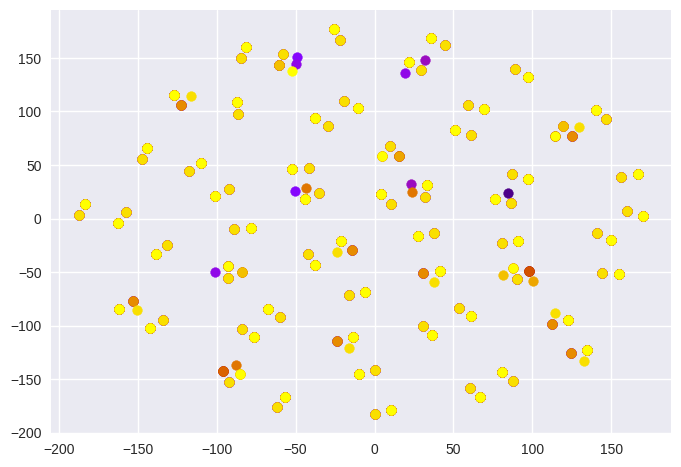

In [ ]:
from sklearn.manifold import TSNE

X_train, y_train, X_test, y_test = get_one_vs_one_data()

X_embedded = TSNE(n_components=2).fit_transform(X_train)

cmap = plt.get_cmap('gnuplot')
color = [np.array([cmap(i)]) for i in np.linspace(0, 1, 23)]
for i in range(2,23):
        idx = np.where(y_train == i)
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=[color[i]], label=i)

## Conclusão

Como demonstrado nessa implementação, o SHAP obteve um grande ganho comparado a utilização de todos os dados. Também foi demonstrado que a condição de parada para a escolha das variáveis pode ser removido, pois resultados melhores podem ser obtidos em troca de maior uso de dados.

Analizando os gráficos produzidos de cada variável escolhida pelo SHAP, nota-se que as variáveis mais importantes são as que tem maior variação nas amostras, aumentando a taxa de detecção dessas falhas. Além disso, em comparação com outros seletores de variáveis, o SHAP apresenta maior consistência na métrica F1 em todos as falhas. O RFE também teve ótimo desempenho, entretanto, na falha 21 não obteve um bom resultado.

Segundo o heatmap, é possível identificar as falhas de acordo com a oscilação de cada variável ao decorrer das amostras, já que para cada falha as primeiras 5 variáveis selecionadas são diferentes entre as demais. Também é possível remover certas variáveis do conjunto de dados, pois não são utilizados pelo SHAP e podem reduzir a acurácia do modelo.



In [1]:
import dill

# dill.dump_session('notebook_sesion.db')
dill.load_session('notebook_sesion.db')

/home/fulanodetau/.local/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/fulanodetau/.local/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_ma

In [1]:
tShap = [0.901,0.890,0.886,0.908,0.896,0.928,0.915, 0.913, 0.909, 0.911, 0.900, 0.919, 0.907, 0.900,]
tRFE = [0.900,0.893,0.885,0.915,0.900,0.928,0.915,0.904,0.913,0.907,0.896,0.919,0.906,0.902,]
tSFM = [0.902,0.887,0.875,0.917,0.899,0.928,0.915,0.913,0.904,0.906,0.892,0.919,0.906,0.900,]
tAnova = [0.902,0.893,0.885,0.915,0.898,0.928,0.915,0.907,0.913,0.902,0.895,0.909,0.906,0.904,]
tMI = [0.902,0.891,0.885,0.915,0.896,0.928,0.912,0.900,0.916,0.913,0.902,0.919,0.900,0.896,]

from scipy.stats import wilcoxon

print("SHAP - RFE",wilcoxon(tShap, tRFE))
print("SHAP - SFM",  wilcoxon(tShap, tSFM))
print("SHAP - ANOVA", wilcoxon(tShap, tAnova))
print("SHAP - MI",  wilcoxon(tShap, tMI))

print("RFE - SFM",  wilcoxon(tRFE, tSFM))
print("RFE - ANOVA",  wilcoxon(tRFE, tAnova))
print("RFE - MI",  wilcoxon(tRFE, tMI))

print("SFM - ANOVA",  wilcoxon(tSFM, tAnova))
print("SFM - MI",  wilcoxon(tSFM, tMI))

print("ANOVA - MI",  wilcoxon(tAnova, tMI))

SHAP - RFE WilcoxonResult(statistic=32.0, pvalue=0.9286588879770015)
SHAP - SFM WilcoxonResult(statistic=13.0, pvalue=0.2591356815716146)
SHAP - ANOVA WilcoxonResult(statistic=34.0, pvalue=0.6943277935069702)
SHAP - MI WilcoxonResult(statistic=31.0, pvalue=0.8582378857679842)
RFE - SFM WilcoxonResult(statistic=16.5, pvalue=0.2603272787106181)
RFE - ANOVA WilcoxonResult(statistic=11.0, pvalue=0.6095233803508289)
RFE - MI WilcoxonResult(statistic=22.0, pvalue=0.5717982372559547)
SFM - ANOVA WilcoxonResult(statistic=23.5, pvalue=0.6828961070561675)
SFM - MI WilcoxonResult(statistic=27.5, pvalue=0.6243206678794846)
ANOVA - MI WilcoxonResult(statistic=26.0, pvalue=0.8782461752097386)


/home/fulanodetau/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/fulanodetau/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
